In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 환경설정
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.0f}'.format

In [103]:
# 데이터 불러오기
credit_card_overdue = pd.read_csv('data/train.csv')
credit_card_overdue_test = pd.read_csv('data/train.csv')

#### 컬럼 정보
* gender: 성별
* car: 차량 소유 여부
* reality: 부동산 소유 여부
* child_num: 자녀 수
* income_total: 연간 소득
* income_type: 소득 분류
    - ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
* edu_type: 교육 수준
    - ['Higer education', 'Secondary/secondary special', Incomplete higher', 'Lower secondary', 'Academic degree']
* family_type: 결혼 여부
    - ['Married', 'Civil marriage', 'Separated', 'Single/not married', 'Window']
* house_type: 생활 방식
    - ['Municipal apartment', 'House/apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']
* DAYS_BIRTH: 출생 일
    - 데이터 수집 당시 (0)부터 역으로 셈
* DAYS_EMPLOYED: 업무시작 일
    - 데이터 수집 당시 (0)부터 역으로 셈 (양수 값은 고용되지 않은 상태)
* FLAG_MOBIL: 핸드폰 소유 여부
* work_phone: 업무용 전화 소유 여부
* phone: (가정용) 전화 소유 여부
* email: 이메일 소유 여부
* occyp_type: 직업 유형(?)
* family_size: 가족 규모
* begin_month: 신용카드 발급 월
    - 데이터 수집 당시 (0)부터 역으로 셈
* credit: 신용등급

In [104]:
credit_card_overdue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [105]:
# 데이터 샘플
credit_card_overdue.head(3)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,"202,500",Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2,-6,1
1,1,F,N,Y,1,"247,500",Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3,-5,1
2,2,M,Y,Y,0,"450,000",Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2,-22,2


In [106]:
# 1차 검사
print(credit_card_overdue['gender'].unique()) # 숫자로 치환
print(credit_card_overdue['car'].unique()) # 숫자로 치환
print(credit_card_overdue['reality'].unique()) # 숫자로 치환
print(credit_card_overdue['income_type'].unique())
print(credit_card_overdue['edu_type'].unique())
print(credit_card_overdue['family_type'].unique())
print(credit_card_overdue['house_type'].unique())
print(credit_card_overdue['FLAG_MOBIL'].unique())
print(credit_card_overdue['work_phone'].unique())
print(credit_card_overdue['phone'].unique())
print(credit_card_overdue['email'].unique())
print(credit_card_overdue['occyp_type'].unique()) # nan -> 'unknown' 변환
print(credit_card_overdue['family_size'].unique()) # 정수 변환
print(credit_card_overdue['begin_month'].unique()) # 정수 변환
print(credit_card_overdue['credit'].unique()) # 정수 변환

# 전처리 기준 설정
# 1) index 컬럼 삭제
# 2) family_size, begin_month, credit : 정수 변환
# 3) FLAG_MOBIL 컬럼 삭제 (∵ 1 뿐이라 의미 없음)
# 4) gender -> {'F': 0, 'M': 1} 변환
# 5) car -> {'N': 0, 'Y': 1} 변환
# 6) reality -> {'N': 0, 'Y': 1} 변환
# 7) occyp_type 값 중 nan -> 'Unknown' 변환
# 8) employed 컬럼 추가 : DAYS_EMPLOYED < 0 인 컬럼
# 9) DAYS_BIRTH, DAYS_EMPLOYED, begin_month -> -변환
# 9) DAYS_EMPLOYED -> 변환 후 양수인 값 NA 처리
# 10) DAYS_BIRTH, DAYS_EMPLOYED -> 숫자형 변환
# 11) DAYS_BIRTH, DAYS_EMPLOYED 컬럼명 -> 소문자 변환

['F' 'M']
['N' 'Y']
['N' 'Y']
['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']
[1]
[0 1]
[0 1]
[0 1]
[nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']
[ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]
[ -6.  -5. -22. -37. -26. -18. -41. -53. -38. -40. -51. -60.  -2. -14.
  -7. -35.  -4. -13. -57. -47. -33. -30. -20.  -8. -39. -21. -19. -24.
 -48. -12. -10. -42. -29.  -3. -23. -25.  -1. -15. -32. -59. -54. -34.
   0. -27. -45. -56. -46.  -

In [107]:
# 전처리 수행
credit_card_overdue_processed = credit_card_overdue.copy()
credit_card_overdue_processed = credit_card_overdue_processed \
    .assign(
        employed = lambda x: x.DAYS_EMPLOYED.apply(lambda y: 1 if y < 0 else 0),
        gender = lambda x: x.gender.apply(lambda y: {'F': 0, 'M': 1}.get(y)),
        car = lambda x: x.car.apply(lambda y: {'N': 0, 'Y': 1}.get(y)),
        reality = lambda x: x.reality.apply(lambda y: {'N': 0, 'Y': 1}.get(y)),
        occyp_type = lambda x: x.occyp_type.fillna('Unknown'),
        DAYS_BIRTH = lambda x: -x.DAYS_BIRTH,
        DAYS_EMPLOYED = lambda x: -x.DAYS_EMPLOYED.apply(lambda y: np.nan if y>0 else y),
        begin_month = lambda x: -x.begin_month,
    ) \
    .astype({'family_size': int, 'begin_month': int, 'credit': int, 'DAYS_BIRTH': float, 'DAYS_EMPLOYED': float}) \
    .rename(columns={'DAYS_BIRTH': 'days_birth', 'DAYS_EMPLOYED': 'days_employed'}) \
    .drop(['index', 'FLAG_MOBIL'], axis=1)

# Null 포함 여부 검사 (days_employed만 null 포함)
print('Null 포함 여부')
display(credit_card_overdue_processed.isna().any(axis=0).to_frame().T)

Null 포함 여부


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,days_birth,days_employed,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employed
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


#### 컬럼별 변수형 분류(총 18개)
* 논리형(6개) :  gender, car, reality, work_phone, phone, email
* 정수형(4개) : child_num, family_size, begin_month, credit(Y)
* 범주형(5개) : income_type, edu_type, family_type, house_type, occyp_type
* 숫자형(3개) : income_total, days_birth, days_employed(nullable)

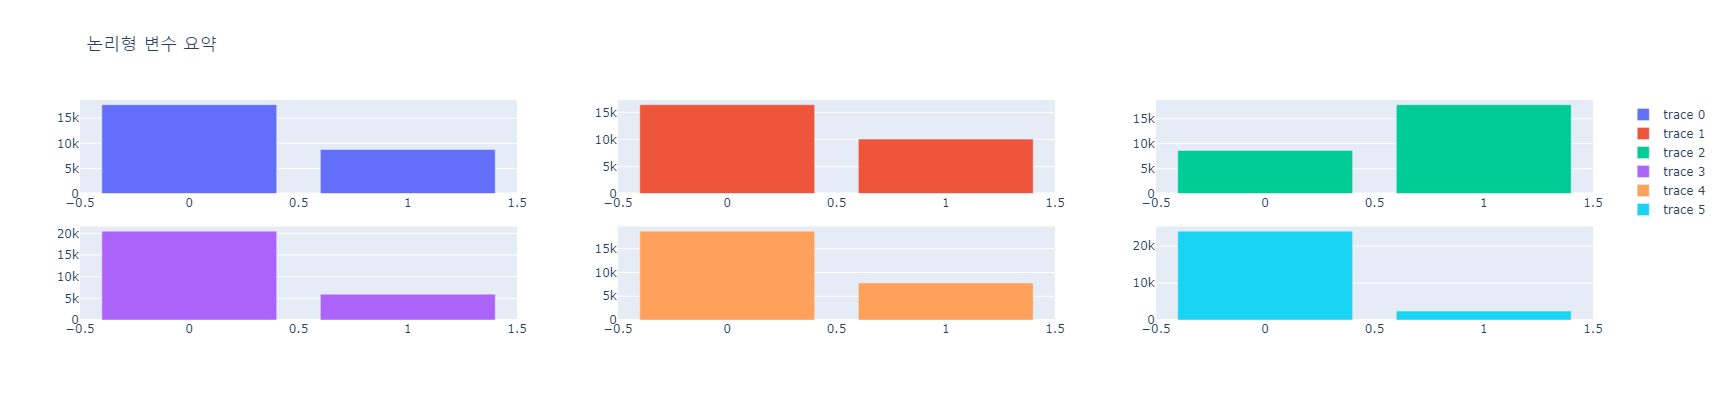

In [112]:
# 논리형 변수 분포 (gender, car, reality, work_phone, phone, email)
gender_cnt = credit_card_overdue_processed.groupby('gender').size().reset_index(name='count')
car_cnt = credit_card_overdue_processed.groupby('car').size().reset_index(name='count')
reality_cnt = credit_card_overdue_processed.groupby('reality').size().reset_index(name='count')
work_phone_cnt = credit_card_overdue_processed.groupby('work_phone').size().reset_index(name='count')
phone_cnt = credit_card_overdue_processed.groupby('phone').size().reset_index(name='count')
email_cnt = credit_card_overdue_processed.groupby('email').size().reset_index(name='count')

fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=gender_cnt['gender'], y=gender_cnt['count']),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=car_cnt['car'], y=car_cnt['count']),
    row=1, col=2
)
fig.add_trace(
    go.Bar(x=reality_cnt['reality'], y=reality_cnt['count']),
    row=1, col=3
)
fig.add_trace(
    go.Bar(x=work_phone_cnt['work_phone'], y=work_phone_cnt['count']),
    row=2, col=1
)
fig.add_trace(
    go.Bar(x=phone_cnt['phone'], y=phone_cnt['count']),
    row=2, col=2
)
fig.add_trace(
    go.Bar(x=email_cnt['email'], y=email_cnt['count']),
    row=2, col=3
)

fig.update_layout(height=400, width=1000, title_text='논리형 변수 요약')
fig.show()

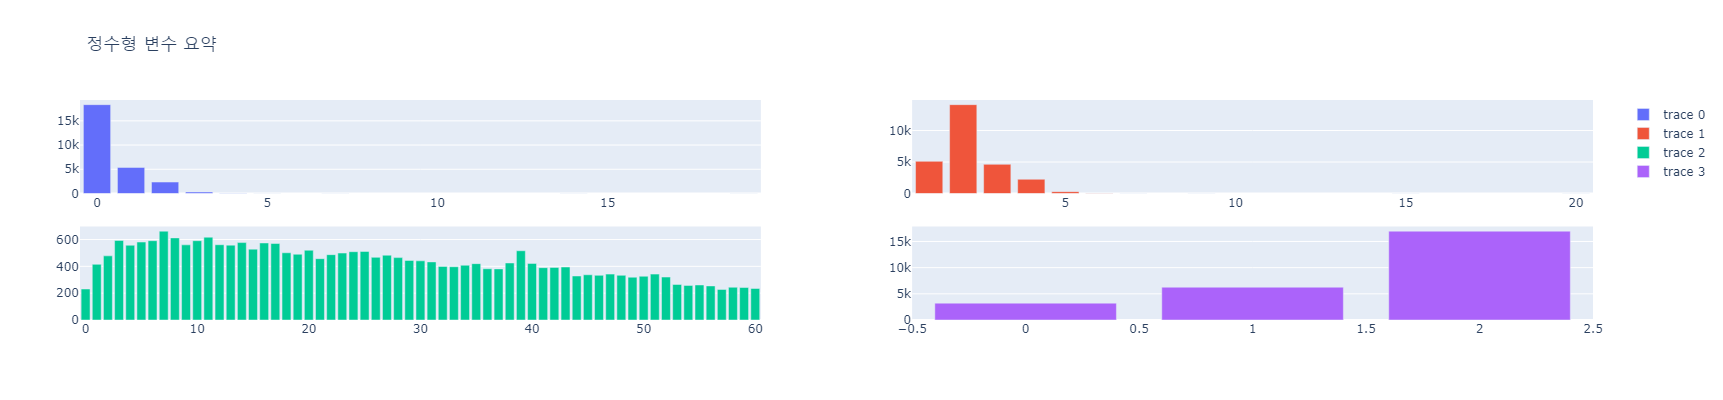

In [113]:
# 정수형 변수 분포 (child_num, family_size, begin_month, credit(Y))
child_num_cnt = credit_card_overdue_processed.groupby('child_num').size().reset_index(name='count')
family_size_cnt = credit_card_overdue_processed.groupby('family_size').size().reset_index(name='count')
begin_month_cnt = credit_card_overdue_processed.groupby('begin_month').size().reset_index(name='count')
credit_cnt = credit_card_overdue_processed.groupby('credit').size().reset_index(name='count')

fig = make_subplots(rows=2, cols=2)

fig.add_trace(
    go.Bar(x=child_num_cnt['child_num'], y=child_num_cnt['count']),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=family_size_cnt['family_size'], y=family_size_cnt['count']),
    row=1, col=2
)
fig.add_trace(
    go.Bar(x=begin_month_cnt['begin_month'], y=begin_month_cnt['count']),
    row=2, col=1
)
fig.add_trace(
    go.Bar(x=credit_cnt['credit'], y=credit_cnt['count']),
    row=2, col=2
)

fig.update_layout(height=400, width=1000, title_text='정수형 변수 요약')
fig.show()

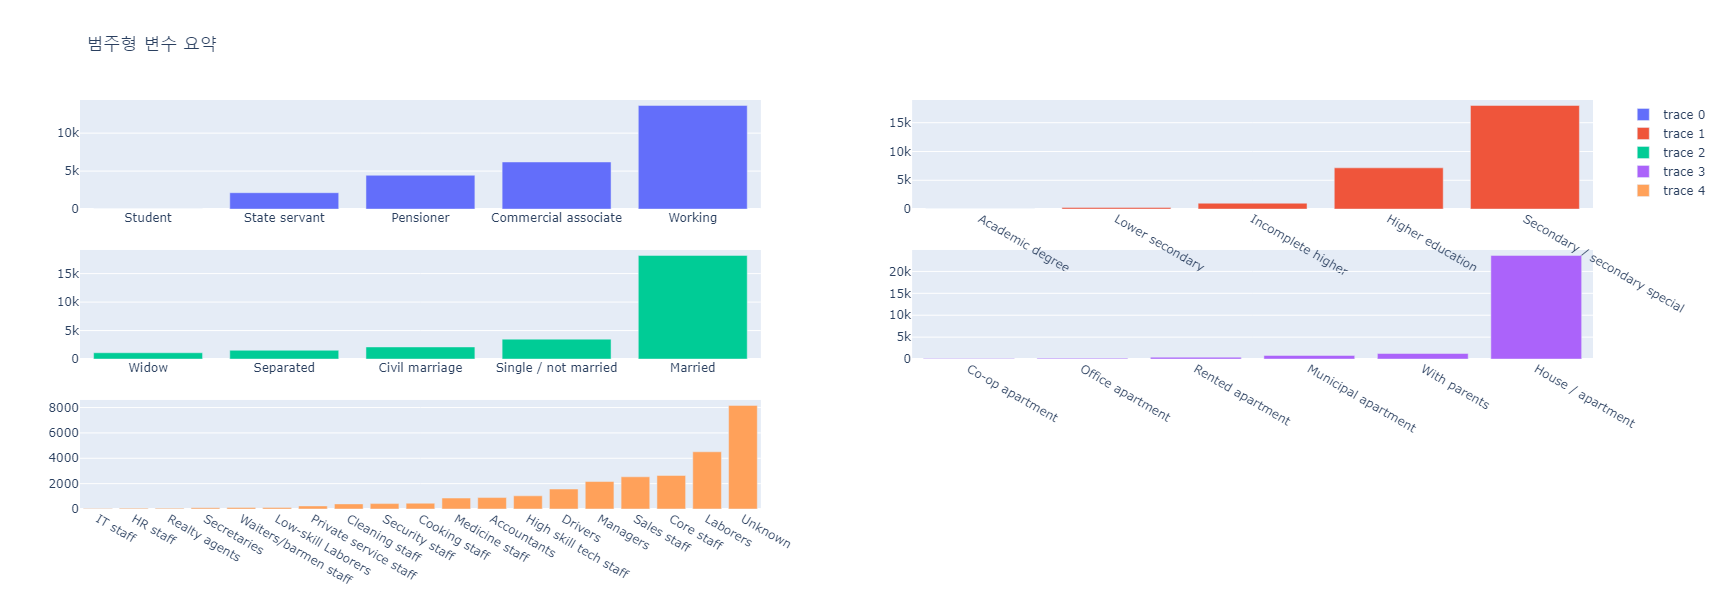

In [129]:
# 범주형 변수 분포 : income_type, edu_type, family_type, house_type, occyp_type
income_type_cnt = credit_card_overdue_processed.groupby('income_type').size().reset_index(name='count').sort_values(by='count')
edu_type_cnt = credit_card_overdue_processed.groupby('edu_type').size().reset_index(name='count').sort_values(by='count')
family_type_cnt = credit_card_overdue_processed.groupby('family_type').size().reset_index(name='count').sort_values(by='count')
house_type_cnt = credit_card_overdue_processed.groupby('house_type').size().reset_index(name='count').sort_values(by='count')
occyp_type_cnt = credit_card_overdue_processed.groupby('occyp_type').size().reset_index(name='count').sort_values(by='count')

fig = make_subplots(rows=3, cols=2)

fig.add_trace(
    go.Bar(x=income_type_cnt['income_type'], y=income_type_cnt['count']),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=edu_type_cnt['edu_type'], y=edu_type_cnt['count']),
    row=1, col=2
)
fig.add_trace(
    go.Bar(x=family_type_cnt['family_type'], y=family_type_cnt['count']),
    row=2, col=1
)
fig.add_trace(
    go.Bar(x=house_type_cnt['house_type'], y=house_type_cnt['count']),
    row=2, col=2
)
fig.add_trace(
    go.Bar(x=occyp_type_cnt['occyp_type'], y=occyp_type_cnt['count']),
    row=3, col=1
)

fig.update_layout(height=600, width=1000, title_text='범주형 변수 요약')
fig.show()

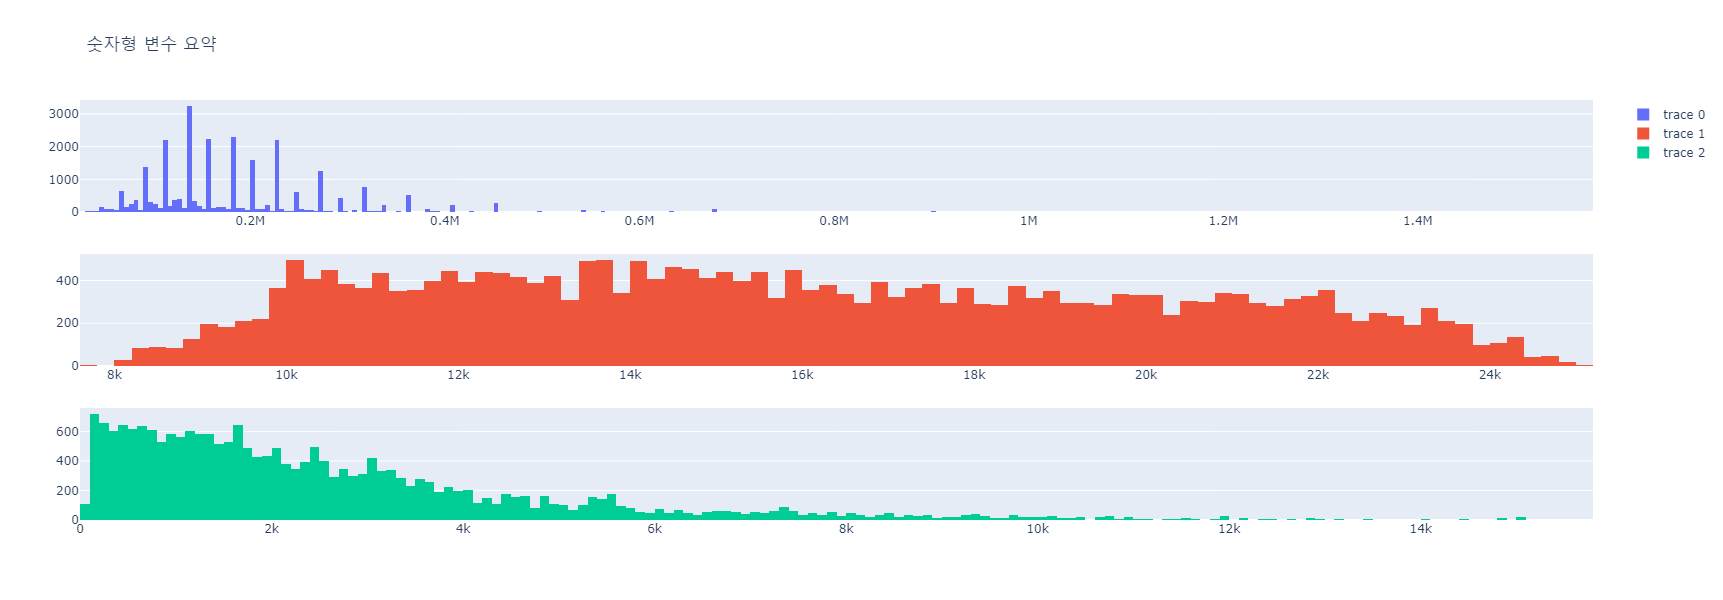

In [133]:
# 숫자형 변수 분포 : income_total, days_birth, days_employed(nullable)
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Histogram(x=credit_card_overdue_processed['income_total']),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=credit_card_overdue_processed['days_birth']),
    row=2, col=1
)
fig.add_trace(
    go.Histogram(x=credit_card_overdue_processed['days_employed']),
    row=3, col=1
)

fig.update_layout(height=600, width=1000, title_text='숫자형 변수 요약')
fig.show()